In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
from tqdm import tqdm
from dateutil import tz
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
#!pip install redis
import redis
redis_ip = '34.211.59.66'
r = redis.StrictRedis(redis_ip)
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

In [2]:
import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags, date, time, date_time  
                from tweets where (date_time >= NOW() - '18 hour'::INTERVAL) and hashtags is not null and hashtags != 'None';'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)
df['created_datetime'] = pd.to_datetime(df['created_at'])
df['year'] = df.created_datetime.apply(lambda x: x.year)
df['month'] = df.created_datetime.apply(lambda x: x.month)
df['day'] = df.created_datetime.apply(lambda x: x.day)
df['hour'] = df.created_datetime.apply(lambda x: x.hour)
len(df)

9342

In [3]:
df = df[~df['hashtags'].str.contains('amp')]
df = df[~df['hashtags'].str.contains('job|hiring|sales|retail|clerical')]
df = df[~df['hashtags'].str.contains('dallas|plano|irving|richardson|garland|allen|odessa|midland|sanfrancisco|losangeles|irvine|garland')]

In [4]:
len(df)

8086

In [5]:
df[~df['location'].str.contains('.ca|california')][~df['location'].str.contains('.tx|texas')]

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,index,cleaned_tweet,created_at,date,date_time,hashtags,location,time,tweet_content,created_datetime,year,month,day,hour
37,37,thank you david for getting me in shape and i...,Mon Jun 12 22:53:49 +0000 2017,2017-06-12,2017-06-12 22:53:49,tapertime seeyouinauburn,"mission, san francisco",22:53:49,@mountainroche thank you david for getting me ...,2017-06-12 22:53:49,2017,6,12,22
41,41,this showcase tho. #xboxe3,Mon Jun 12 22:53:56 +0000 2017,2017-06-12,2017-06-12 22:53:56,xboxe3,galen center (gec),22:53:56,this showcase tho. #xboxe3 https://t.co/katndt...,2017-06-12 22:53:56,2017,6,12,22
109,109,like two peas in a...pizza? - roasted artichok...,Mon Jun 12 22:57:12 +0000 2017,2017-06-12,2017-06-12 22:57:12,vegan,true food kitchen,22:57:12,like two peas in a...pizza? - roasted artichok...,2017-06-12 22:57:12,2017,6,12,22
216,216,"i don't eat sliders but when i do, i go for th...",Mon Jun 12 23:01:21 +0000 2017,2017-06-12,2017-06-12 23:01:21,pureaccelerate2017,anchor distilling company,23:01:21,"i don't eat sliders but when i do, i go for th...",2017-06-12 23:01:21,2017,6,12,23
268,268,"yet more bargain books!! fantastic titles, all...",Mon Jun 12 23:03:26 +0000 2017,2017-06-12,2017-06-12 23:03:26,actionthrillers,mexico,23:03:26,"yet more bargain books!! fantastic titles, all...",2017-06-12 23:03:26,2017,6,12,23
272,272,"yet more bargain books!! fantastic titles, all...",Mon Jun 12 23:03:38 +0000 2017,2017-06-12,2017-06-12 23:03:38,actionthrillers,mexico,23:03:38,"yet more bargain books!! fantastic titles, all...",2017-06-12 23:03:38,2017,6,12,23
331,331,fish fest fun! #apusoe,Mon Jun 12 23:05:55 +0000 2017,2017-06-12,2017-06-12 23:05:55,apusoe,honda center,23:05:55,fish fest fun! #apusoe https://t.co/zwq9yqhbt9,2017-06-12 23:05:55,2017,6,12,23
416,416,waiting sucks. #playstatione3 #e32017,Mon Jun 12 23:09:10 +0000 2017,2017-06-12,2017-06-12 23:09:10,playstatione3 e32017,regal cinemas la live 14,23:09:10,waiting sucks. #playstatione3 #e32017 https://...,2017-06-12 23:09:10,2017,6,12,23
417,417,✨j. maruyama kingdom of cute merch is in stock...,Mon Jun 12 23:09:11 +0000 2017,2017-06-12,2017-06-12 23:09:11,kingdomofcute jmaruyama disneyland,downtown disney,23:09:11,✨💜j. maruyama kingdom of cute merch is in stoc...,2017-06-12 23:09:11,2017,6,12,23
418,418,"she tells it exactly as it is, we dont want #h...",Mon Jun 12 23:09:11 +0000 2017,2017-06-12,2017-06-12 23:09:11,hitler islam muhammad buildthewall lawandorder,edge of the pacific ocean,23:09:11,"she tells it exactly as it is, we dont want #h...",2017-06-12 23:09:11,2017,6,12,23


In [6]:
ca_df = df[df['location'].str.contains('.ca|california')]
tx_df = df[df['location'].str.contains('.tx|texas')]

In [7]:
def word_cloud(state = None): 
    state = state.lower()
    state_df = df[df['location'].str.contains('.{}'.format(state))]
    words = state_df['hashtags'][(state_df['hashtags'].isnull() == False) & (state_df['hashtags'] != 'None')]
    stopwords = set(STOPWORDS)
    #stopwords.add("amp")
    wc = WordCloud(width=1600, height=800, background_color='white', \
                   relative_scaling=1, stopwords=stopwords, colormap='copper').generate(' '.join(i for i in words))
    plt.figure(figsize=(20,10))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    return

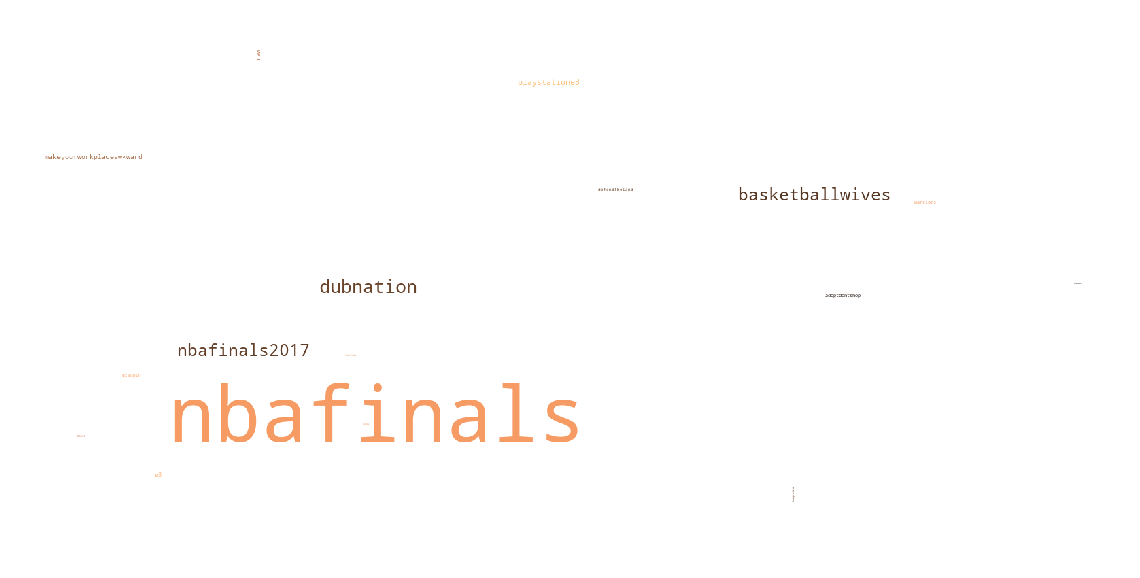

In [8]:
word_cloud('TX')

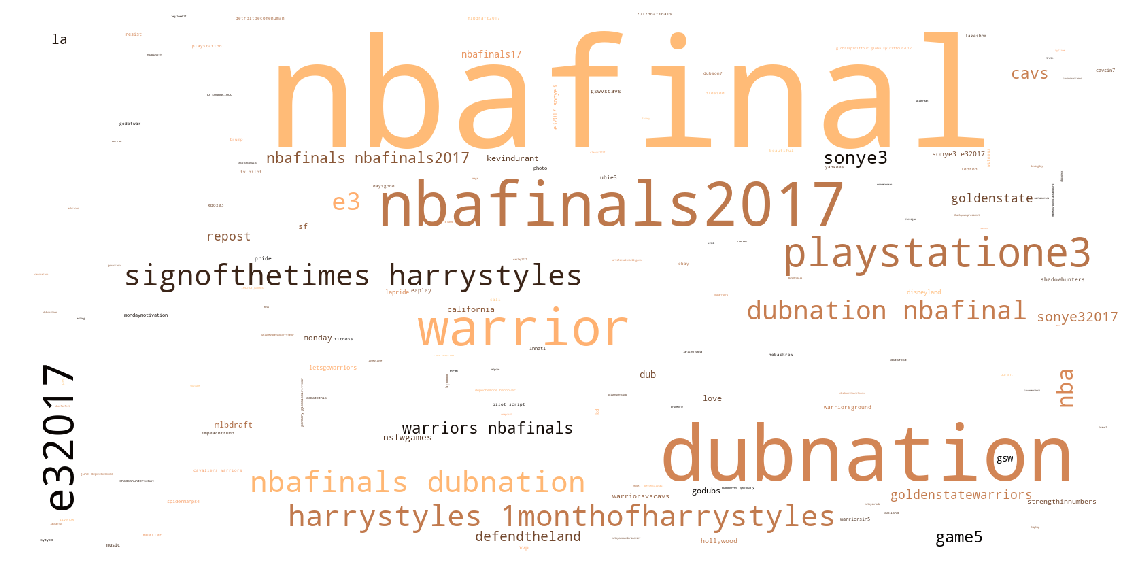

In [9]:
word_cloud('CA')

In [10]:
hastages_series = df['hashtags']
len(hastages_series)

8086

In [11]:
count_vectorizer = CountVectorizer(min_df = 1, stop_words='english')
hashtags_countvec = count_vectorizer.fit_transform(hastages_series)
#hashtags_countvec = pickle.dumps(hashtags_countvec_fit)
#r.set('hashtags_countvec_fit_temp', hashtags_countvec)
#hashtags_countvec = pickle.loads(r.get('hashtags_countvec_fit_temp'))

In [12]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = .25)
time_gap = timedelta(hours = 0.1)
windows = int(round(time_delta/time_gap,0))
print('start time: ', min(df['created_datetime']),'\n',\
      'end time:  ', max(df['created_datetime']),'\n',\
      'total hours: ',time_window,'\n',\
      'time lag: ', time_lag,'\n',\
      'time gap: ', time_gap,'\n',\
      'time windows: ', windows)

start time:  2017-06-12 22:52:00 
 end time:   2017-06-13 04:00:55 
 total hours:  5 
 time lag:  0:15:00 
 time gap:  0:06:00 
 time windows:  51


In [13]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    
    return result

In [14]:
def new_trend_period(trend_group):        
    new_result = []
    count = 0
    for i in range(len(trend_group)-1):
        if (count > len(trend_group)-2):
            pass
        else:
            gap = ((trend_group[count+1][0]) - (trend_group[count][len(trend_group[count])-1]))
            if gap <.8*min((trend_group[count+1][0]), (trend_group[count][len(trend_group[count])-1])):
                new_period = trend_group[count]+trend_group[count+1]
                new_result.append(new_period)
                count +=2
            else:
                new_result.append(trend_group[count])
                count +=1
    return new_result

In [15]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = .3)
time_gap = timedelta(hours = .1)
windows = int(round(time_delta/time_gap,0))
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
to_zone = 'US/Pacific'
def hashtag_trend(hashtag):
    hashtag = hashtag.lower()
    arr = []
    arr_all = []
    start_time = min(df['created_datetime'])
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        #arr_all.append(subset.mean())
        start_time += time_gap
    w = np.array(range(windows))
    timeline = []
    for i in w:
        timeline.append(min(df['created_datetime']) + time_gap * i) 
    arr = np.array(arr)  
    #arr_all = np.array(arr_all) 
    grad = np.gradient(arr)
    #grad2 = np.gradient(grad)
    #tr = np.argwhere(grad>.01).reshape(1,-1)[0]
    time_df = pd.DataFrame({'arr':arr,'grad':grad},index=timeline)
    rolmean_arr = pd.rolling_mean(arr, window=12)
    rolstd_arr = pd.rolling_std(arr, window=12)
    rolmean_grad = np.gradient(rolmean_arr)
    spike = []
    trend = np.argwhere(rolmean_grad>0.001).reshape(1,-1)[0]
    trend_group = group_consecutives(trend)
        
    trend_group1 = new_trend_period(trend_group)
    #if trend_group1 != trend_group:
    #    trend_group1 = new_trend_period(trend_group1)
        
    trend_group2 = [i for i in trend_group1 if (len(i) > 7)]
    spike.append([[i[0],i[len(i)-1]] for i in trend_group2])
    spike = np.array(spike)
    spk1 = [i[0] for i in spike[0]]
    spk2 = [i[1] for i in spike[0]]
        
    plt.figure(figsize=(14,7))
    plt.plot(arr, label='Hashtag Frequency',c = 'navy')
    plt.plot(rolmean_arr, label='Rolling Means',c = 'lightblue')
    plt.plot(rolstd_arr, label='Rolling STDs',c = 'gray')
    plt.plot(rolmean_grad, label='Gradient over Rolling Means',c = 'red')
    #plt.plot(grad2, label='grad2 Slope')
    for j,k in zip(spk1,spk2):
        spike1 = (min(df['created_datetime']) + time_gap * j) 
        spike1 = spike1.replace(tzinfo=from_zone)
        spike1_et = spike1.astimezone(to_zone)
        spike1_et = spike1_et.strftime(time_format)
       
        spike2 = (min(df['created_datetime']) + time_gap * k) 
        spike2 = spike2.replace(tzinfo=from_zone)
        spike2_et = spike2.astimezone(to_zone)
        spike2_et = spike2_et.strftime(time_format)           
        plt.axvline(j, color = 'salmon',linestyle='dashed', label = 'Trending: {}'.format(spike1_et))
        plt.axvspan(j, k, alpha=0.2, color='lightcoral')
    plt.title(hashtag, fontsize=20)    
    plt.legend(fontsize=12) 
    ### -----ARIMA MODELING
#     from statsmodels.tsa.arima_model import ARIMA
#     w = np.array(range(windows))
#     timeline = []
#     for i in w:
#         timeline.append(min(df['created_datetime']) + time_gap * i) 
#     arima_df = pd.DataFrame({'perf':arr},index=timeline)   

#     series = arima_df
#     model = ARIMA(series, order=(5,1,0))
#     model_fit = model.fit()
#     print(model_fit.summary())
#     # plot residual errors
#     residuals =pd. DataFrame(model_fit.resid)
#     residuals.plot()
#     plt.show()
#     residuals.plot(kind='kde')
#     plt.show()
#     print(residuals.describe())
    ###-----------------
    return  time_df

In [16]:
hashtag_freq_df = pd.DataFrame({'hashtag': count_vectorizer.get_feature_names(), 'occurrences':np.asarray(hashtags_countvec.sum(axis=0)).ravel().tolist()})
hashtag_freq_df['frequency'] = hashtag_freq_df['occurrences']/np.sum(hashtag_freq_df['occurrences'])
hashtag_freq_df.sort_values(by = 'occurrences',ascending = False, inplace = True)

In [17]:
hashtag_freq_df.head(10)

,hashtag,occurrences,frequency
4161,nbafinals,1007,0.066570
1738,dubnation,523,0.034574
4163,nbafinals2017,314,0.020758
6595,warriors,267,0.017651
1776,e32017,239,0.015800
4688,playstatione3,185,0.012230
1773,e3,108,0.007140
5579,sonye3,102,0.006743
36,1monthofharrystyles,97,0.006412
5430,signofthetimes,97,0.006412


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:33: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:34: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


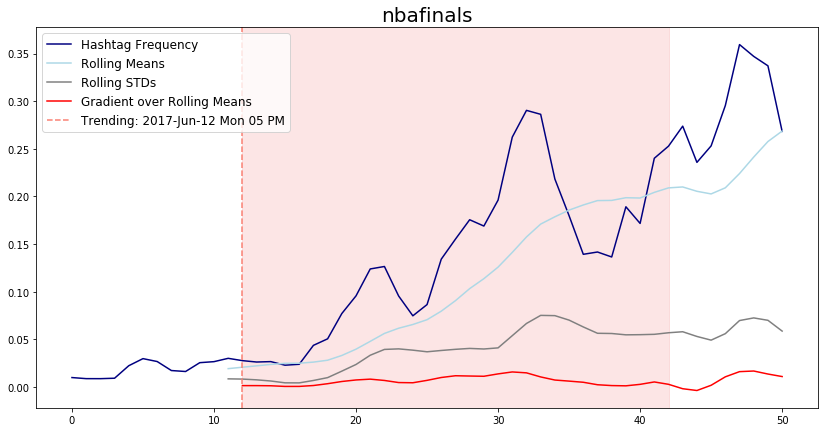

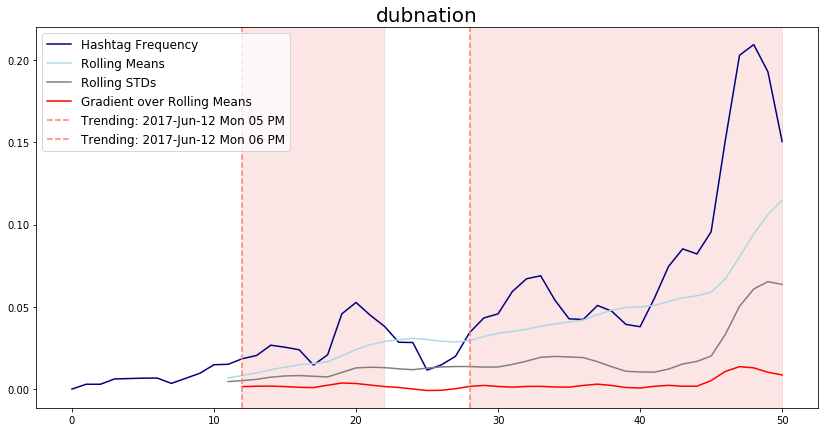

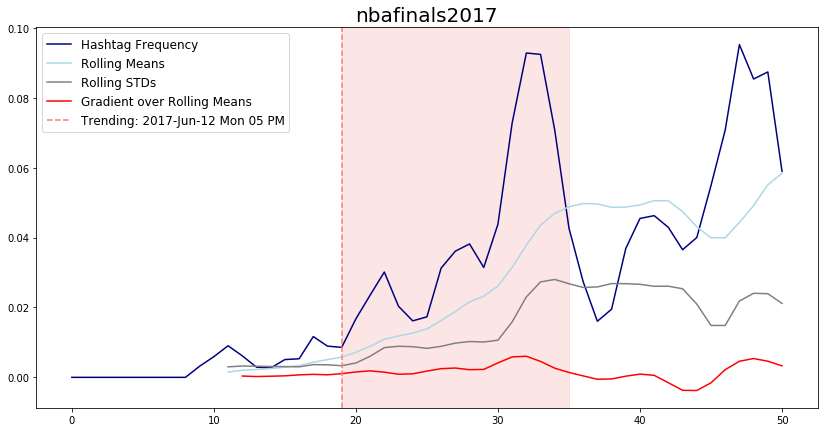

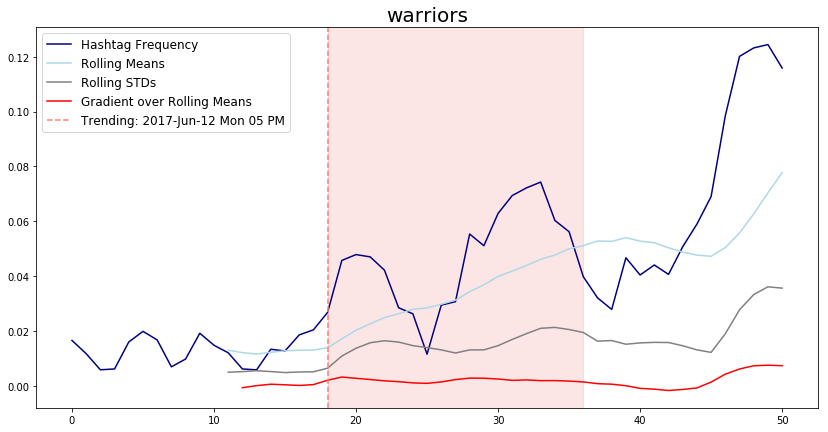

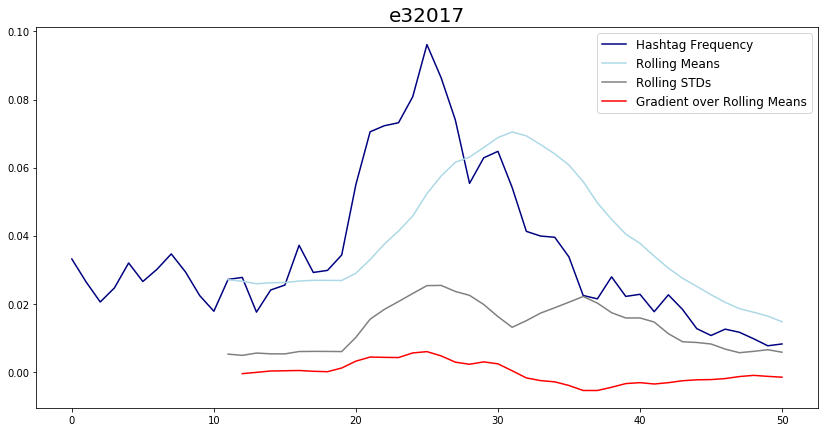

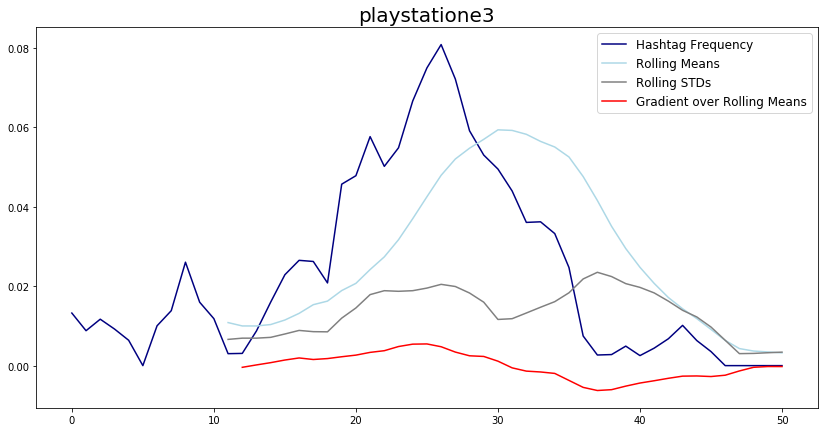

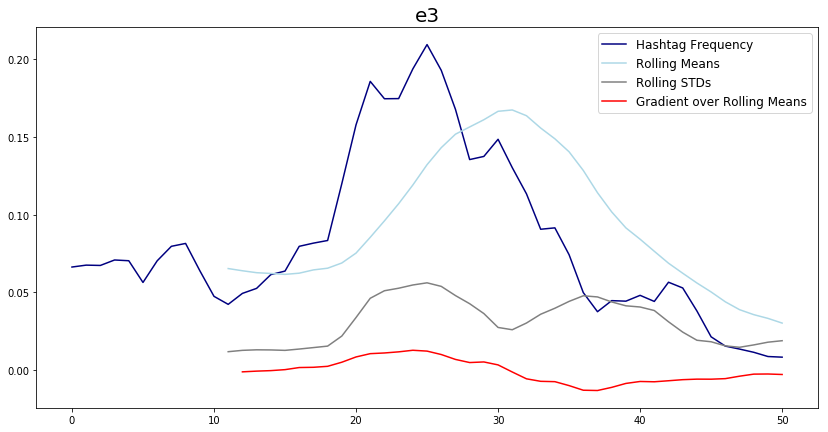

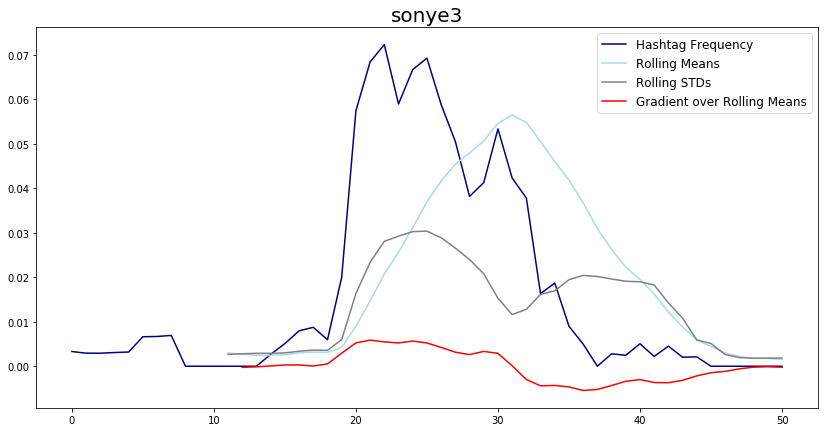

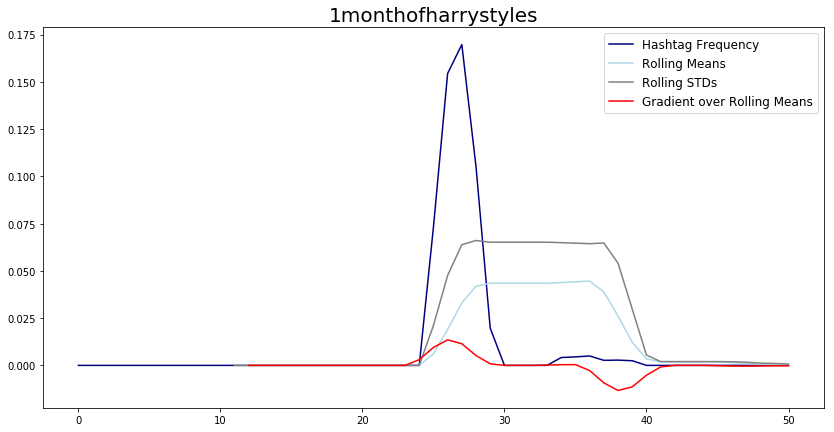

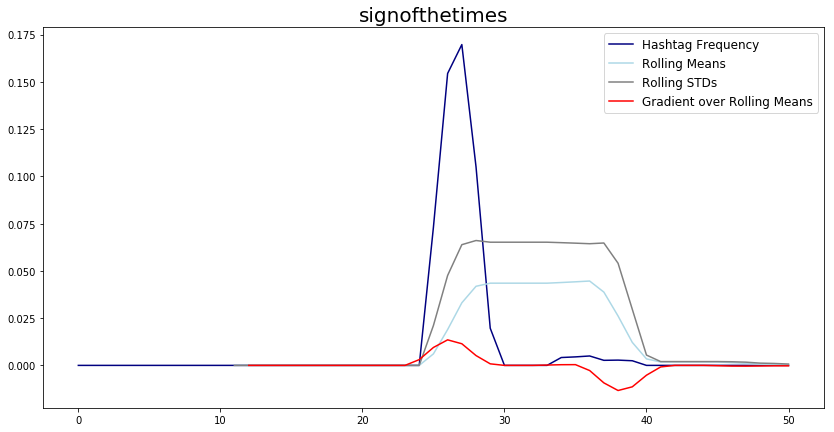

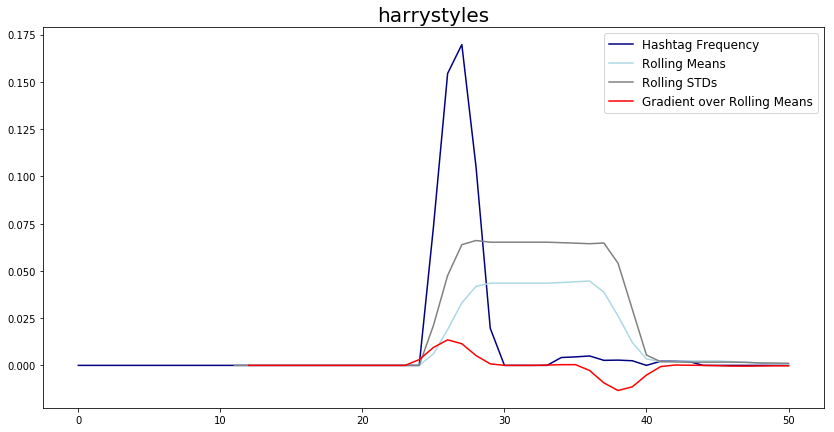

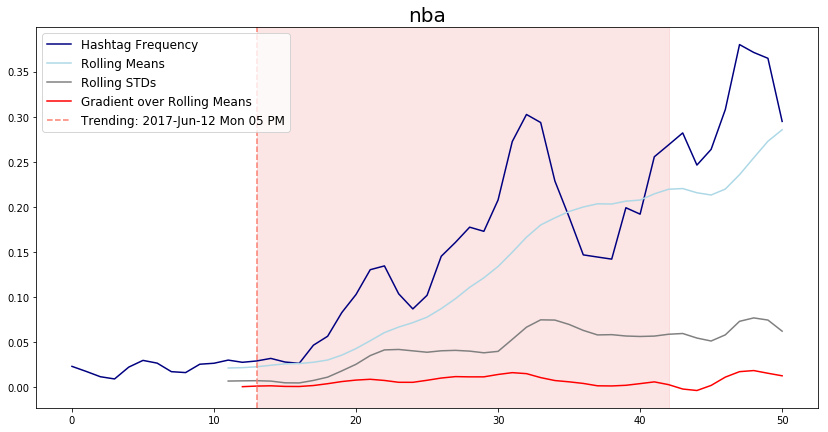

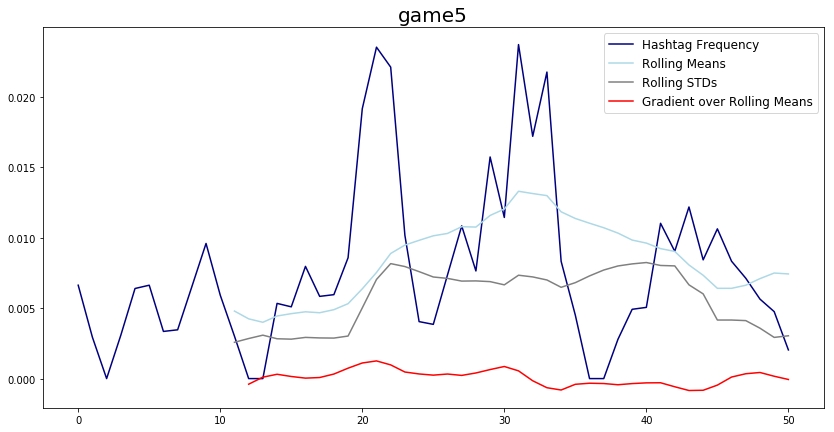

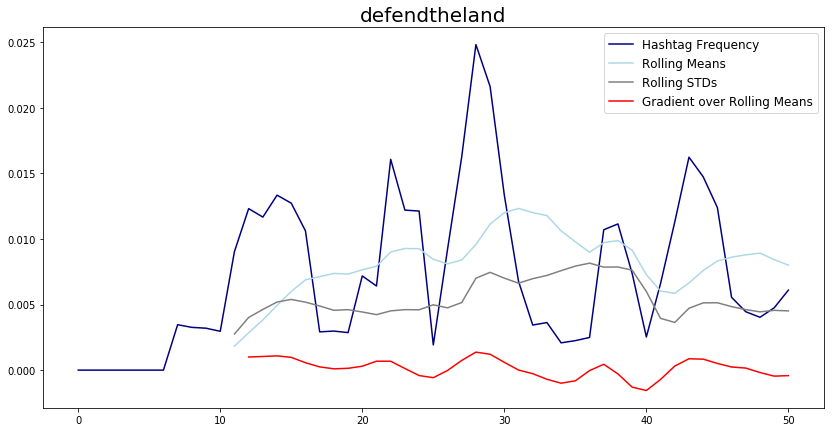

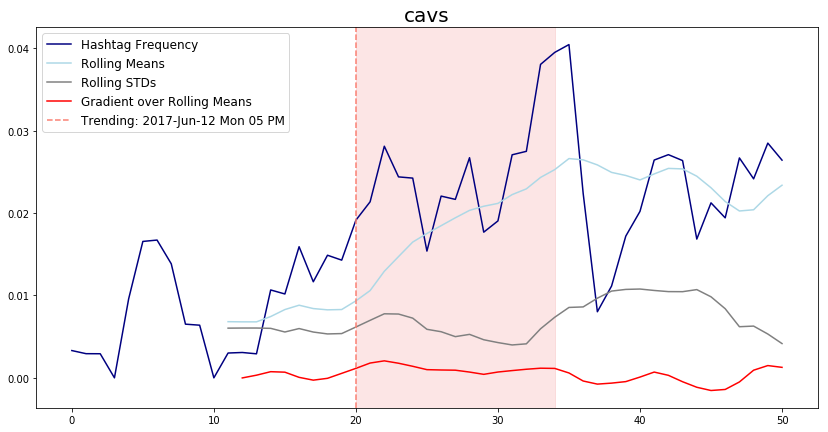

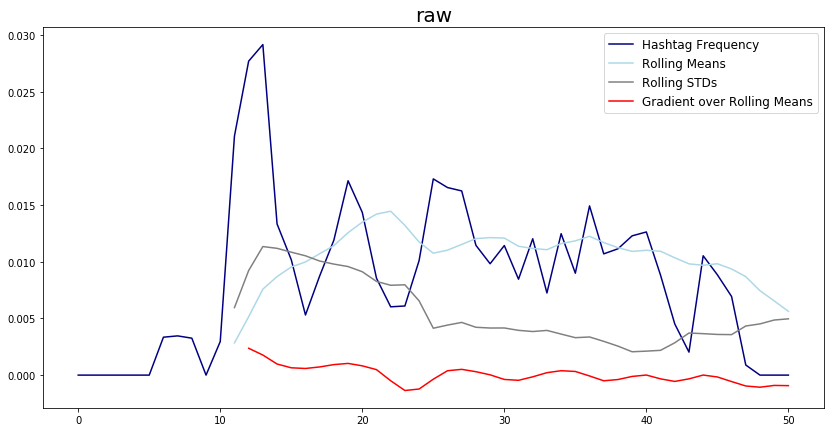

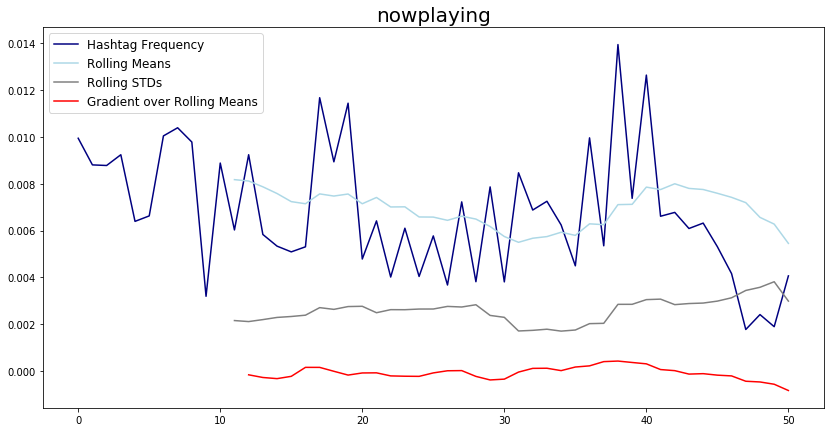

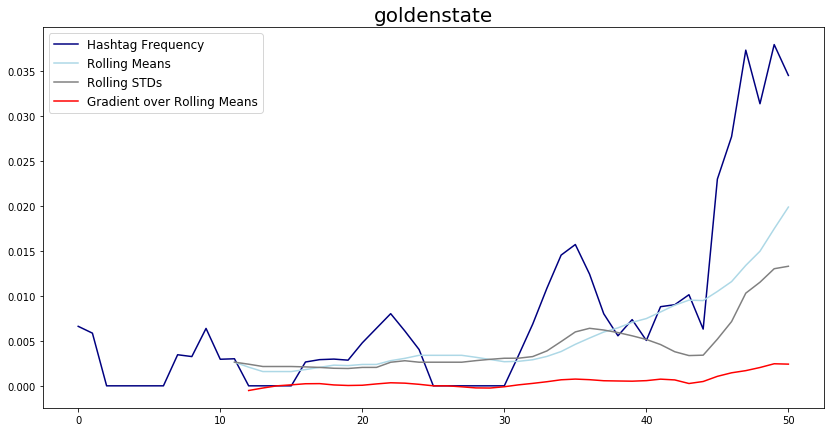

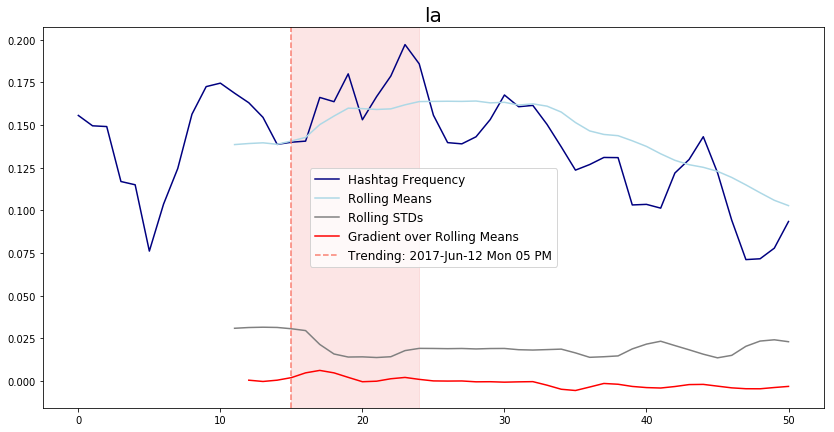

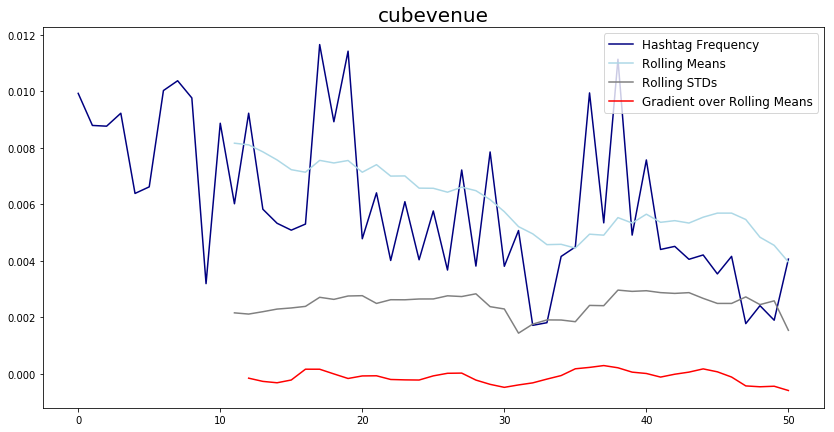

In [20]:
a = [hashtag_trend(i) for i in (hashtag_freq_df['hashtag'].head(20))]

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:33: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:34: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


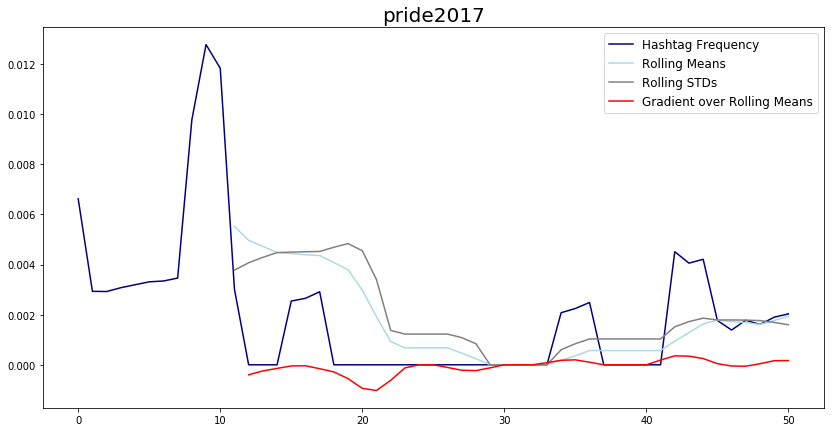

In [19]:
time_df = hashtag_trend('pride2017')